In [2]:
import omegaconf
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ultk.effcomm.rate_distortion import ib_encoder_to_point

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")
from game.game import Game

from tqdm import tqdm


In [3]:
# Fix one param config

parent = Path("/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=imprecise_conditional_imitation/ii=0/discr_need=0/population_init=0/population_size=None/num_runs=1/seed=0")

config = omegaconf.OmegaConf.load(parent / ".hydra/config.yaml")
g = Game.from_hydra(config)

In [4]:
# bound data
betas = np.load('/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/betas.npy')

optimal_encoders = np.load('/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/optimal_encoders.npy')

curve_data = pd.read_csv('/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/curve_points.csv')


# simulation data

emergent_encoders = np.load('/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=imprecise_conditional_imitation/ii=0/discr_need=0/population_init=0/population_size=None/num_runs=1/seed=0/final_encoders.npy')

sim_data = pd.read_csv('/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=imprecise_conditional_imitation/ii=0/discr_need=0/population_init=0/population_size=None/num_runs=1/seed=0/simulation_points.csv')


In [5]:
curve_points = curve_data[["complexity", "accuracy"]].values

In [6]:
# todo: filter beta to approapriate values
curve_points = curve_points[1:]
betas = betas[1:]

In [7]:
# Measure efficiency loss 1/beta (F_emergent - F_optimal) to any F_optimal
# F_[q] = em_complexity - em_acc
# eps = 1/beta * ( F_[q] - F_[q*] )
F_opt = curve_points[:,0] - betas * curve_points[:,1]

for em in tqdm(emergent_encoders, desc="looping over encoders"):
    comp, acc, _ = ib_encoder_to_point(g.prior, g.meaning_dists, em)
    F_em = comp - betas * acc

    # Do we have F_[q] >= F_[q*] for all q?
    F_em_deviation = F_em - F_opt
    min_ind = np.argmin(F_em_deviation)

    beta_em = betas[min_ind]
    epsilon_em = np.min(F_em_deviation) / beta_em
    fitted_opt = optimal_encoders[min_ind]

    
    print(epsilon_em)

    if epsilon_em < 0:
        print(epsilon_em)
        assert False


looping over encoders:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/nathanielimel/uw/projects/ultk/src/ultk/effcomm/rate_distortion.py:137: RuntimeWarning: invalid value encountered in multiply
looping over encoders: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]

nan


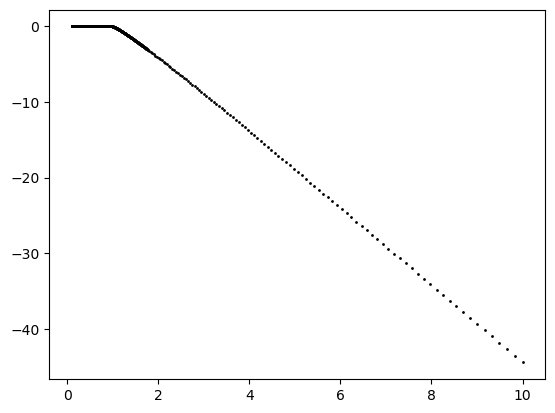

In [8]:
plt.scatter(betas, F_opt, color="black", s=1)
plt.scatter(betas, F_em, color="red", s=1)
plt.show()

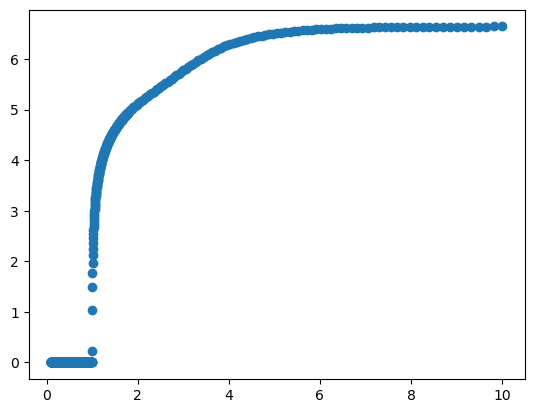

In [9]:
plt.scatter(betas, curve_points[:,0])
plt.show()

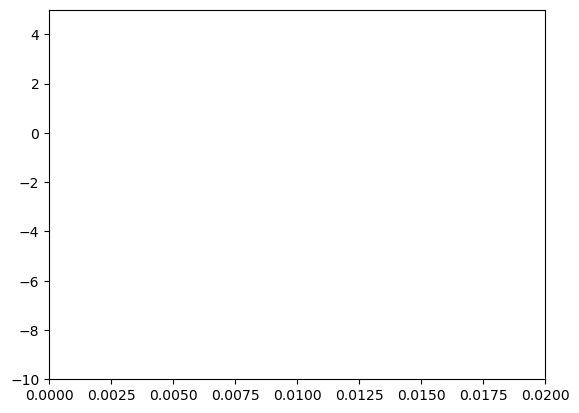

In [10]:
plt.scatter(betas, F_opt, color="black", s=1)
plt.scatter(betas, F_em, color="red", s=1)
plt.xlim(0,0.02)
plt.ylim(-10, 5)
plt.show()

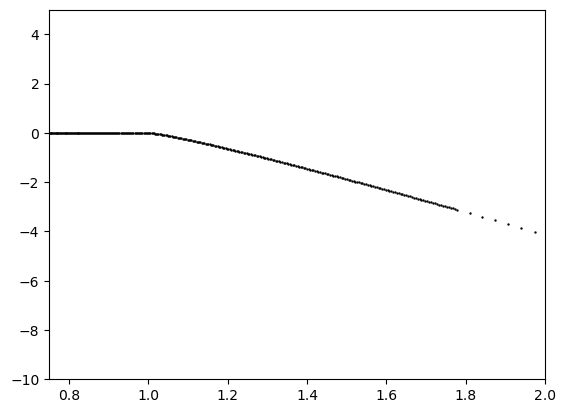

In [11]:
plt.scatter(betas, F_opt, color="black", s=0.5)
plt.scatter(betas, F_em, color="red", s=0.5)
plt.xlim(0.75,2)
plt.ylim(-10, 5)
plt.show()

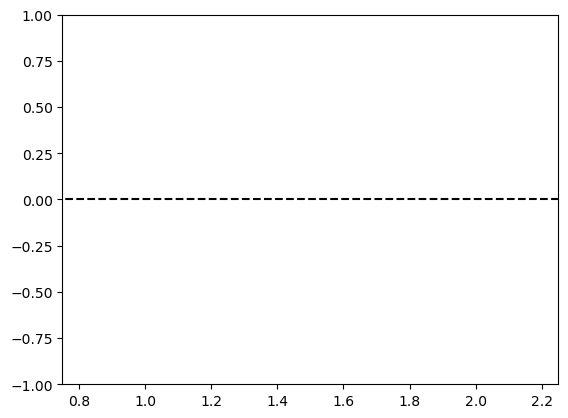

In [12]:
plt.scatter(betas, F_em - F_opt, s=1)
plt.hlines(0, 0, 4, color="black", linestyles='dashed')
plt.xlim(0.75,2.25)
plt.ylim(-1, 1)
plt.show()

Ruling out that the source is numerical instability in the region $\beta = [1.0,2.0]$

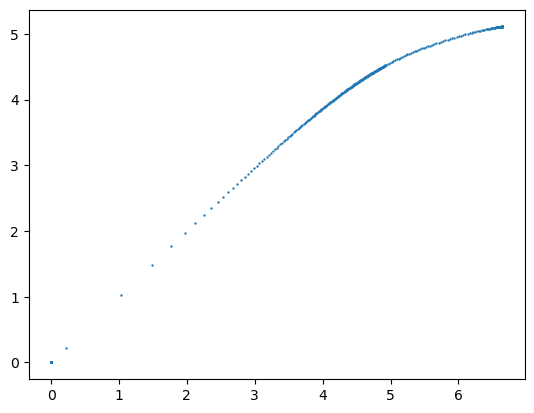

In [13]:
plt.scatter(*curve_points.T, s=0.5)

Text(0.5, 0, '$\\log_{2} \\beta$')

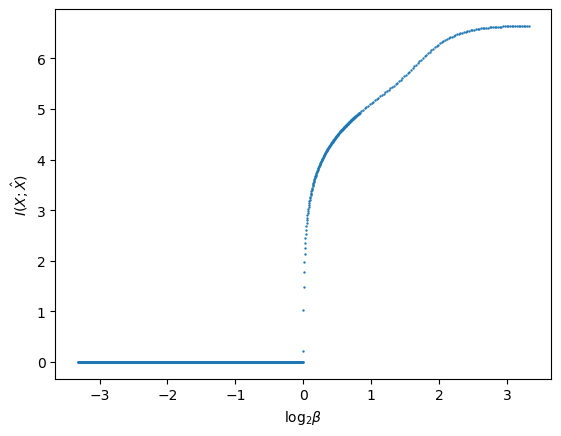

In [14]:
# what are the complexity values for beta 0.8 to 2.2?
# plt.scatter(betas[:1800], curve_points[:,1][:1800], s=0.5,)
plt.scatter(np.log2(betas), curve_points[:,0], s=0.5)
plt.ylabel(r"$I(X;\hat{X})$")
plt.xlabel(r"$\log_{2} \beta$")

In [15]:
# Why are the encoders before beta=1 not 0 complexity
betas[1600]
curve_points[1600,0]
plt.imshow(optimal_encoders[1000])

IndexError: index 1600 is out of bounds for axis 0 with size 1098

In [ ]:
# WHAT ARE THEY

curve_points[1500]

array([3.49360857, 3.42710375])

(0.8, 2.2)

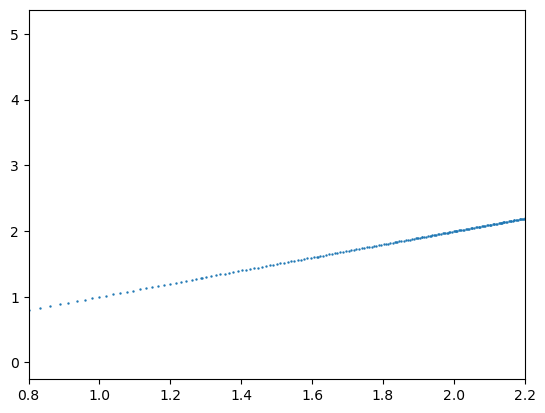

In [ ]:
plt.scatter(*curve_points.T, s=0.5)
plt.xlim(0.8, 2.2)

(0.5, 2.0)

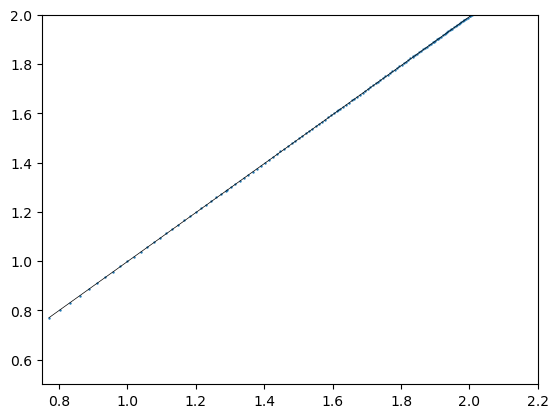

In [ ]:
# Idea draw a line between the y value at 0.8 and the y value at 2.0, and check if the blue line is below it.
import numpy as np
np.set_printoptions(suppress=True)
index1 = 620
index2 = 800
xy1 = curve_points[index1]
xy2 = curve_points[index2]
plt.scatter(*curve_points.T, s=0.5)
plt.plot([xy1[0], xy2[0]], [xy1[1], xy2[1]], color="black", linewidth=0.5)
plt.xlim(0.75, 2.2)
plt.ylim(0.5,2)

Ruling out that the source of trouble is from an encoder that doesn't sum to 1.0

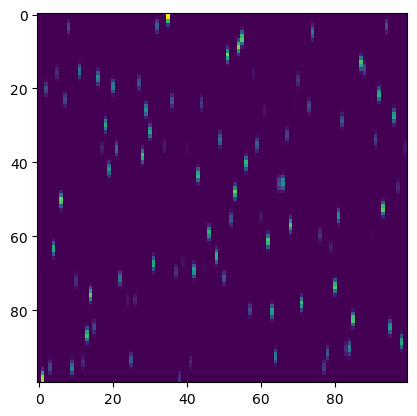

In [ ]:
plt.imshow(em)
plt.show()

In [ ]:
em.sum(1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
comp, acc

(4.476589070012617, -36.349141366637504)